In [1]:
%matplotlib inline

import hyperspy.api as hs
import pyxem as pxm
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl

from pathlib import Path

from matplotlib.colors import SymLogNorm, to_rgba, LinearSegmentedColormap

from skimage.filters.thresholding import try_all_threshold, threshold_triangle, threshold_li, threshold_isodata
from skimage.measure import label

color_names = ['linen', 'darkorange', 'dodgerblue', 'forestgreen', 'red']
colors = [to_rgba(c) for c in color_names]

cmap = LinearSegmentedColormap.from_list('gt_cmap', colors, N=len(color_names))

gray_cmap = plt.colormaps.get('Greys')
gray_cmap.set_bad('lightblue')

In [2]:
def union_mask(masks, invert=True):
    """
    Return the union between masks in a list
    
    Masks should be `True` wherever data is to be be excluded in processing/analysis. 
    
    Parameters
    ----------
    masks : array-like
            A list of hyperspy 2DSignal objects of shape (|nx, ny).
    invert : bool
            Whether to invert the masks before taking the union (usually needed for hyperspy masks). The final mask will be re-inverted before returning.
    
    Returns
    --------
    mask : hyperspy.signals.2DSignal
            The union of the provided masks with shape (|nx, ny).
    """
    if invert:
        masks = [~mask for mask in masks]
    
    mask = masks.pop()
    for m in masks:
        mask = mask & m
    
    if invert:
        mask = ~mask
        
    mask.metadata.General.title = 'Mask'
        
    return mask
    
def estimate_threshold(loadings, component, method=None):
    """
    Estimate the best threshold for a loading map component
    
    Returns a value suited for thresholding a specific loading corresponding to a component of a decomposition algorithm.
    
    Parameters
    ----------
    loadings : hyperspy.signals.2DSignal
            The decomposition loadings of a signal
    component : int
            The component to estimate the threshold for
    method : Union(None, str)
            The method to use for estimating thresholds. If None, it will try all threshold methods and output a plot for evaluation.
            
    Returns
    -------
    threshold : None or float
            Returns None if `method`=None, otherwise it will return the threshold estimated by the provided method.
    
    """
    
    if method is None:
        _ = try_all_threshold(np.nan_to_num(loadings.inav[component].data, copy=True, nan=np.nanmin(loadings.inav[component].data)))
        fig = plt.gcf()
        fig.suptitle(component)
    else:
        return method(np.nan_to_num(loadings.inav[component].data, copy=True, nan=np.nanmin(loadings.inav[component].data)))

# Dataset A

## Define phase dictionary

In [3]:
phases = {
    'theta_100': {'value': 1.0, 'components': tuple(), 'thresholds': {}},
    'theta_001': {'value': 2.0, 'components': tuple(), 'thresholds': {}},
    'T1': {'value': 3.0, 'components': tuple(), 'thresholds': {}}
}

## Load and prepare data

In [4]:
filepath = Path(r'/media/emilc/Data21/Data/PhaseMapping/Dataset A/datasetA_preprocessed.hspy')

[<Axes: title={'center': 'Integrated intensity'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>,
 <Axes: title={'center': 'Dataset A'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>]

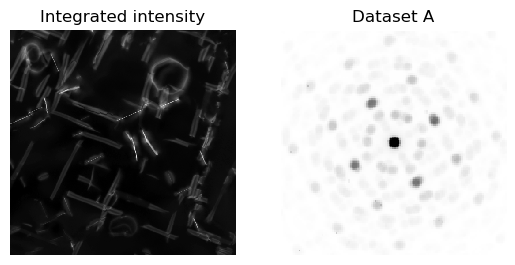

In [5]:
s = hs.load(str(filepath), lazy=False)
s.change_dtype('float32')
vbf = s.get_integrated_intensity(hs.roi.CircleROI(0.0, 0.0, 0.1))
maximums = s.max(axis=[0, 1])
try:
    vbf.compute()
    maximums.compute()
except AttributeError:
    pass
hs.plot.plot_images([vbf, maximums], norm='symlog', axes_decor='off', colorbar=None, cmap='gray_r')

In [6]:
s.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── Diffraction
│       │       ├── camera_length = 23.036135801743175
│       │       └── exposure_time = 10
│       ├── beam_energy = 200
│       ├── rocking_angle = 1.04
│       ├── rocking_frequency = 100
│       └── scan_rotation = 0
├── General
│   ├── FileIO
│   │   ├── 0
│   │   │   ├── hyperspy_version = 1.7.3
│   │   │   ├── io_plugin = hyperspy.io_plugins.hspy
│   │   │   ├── operation = save
│   │   │   └── timestamp = 2023-05-28T12:18:54.719021+02:00
│   │   ├── 1
│   │   │   ├── hyperspy_version = 1.7.3
│   │   │   ├── io_plugin = hyperspy.io_plugins.hspy
│   │   │   ├── operation = load
│   │   │   └── timestamp = 2023-05-28T12:32:34.660832+02:00
│   │   ├── 2
│   │   │   ├── hyperspy_version = 1.7.3
│   │   │   ├── io_plugin = hyperspy.io_plugins.hspy
│   │   │   ├── operation = save
│   │   │   └── timestamp = 2023-05-28T12:44:12.493160+02:00
│   │   └── 3
│   │       ├── hyperspy_version = 1.7.3
│   │       ├── io_plugin = hyperspy.io_plugins.hspy
│   │       ├── operation = load
│   │       └── timestamp = 2023-07-03T23:18:48.632172+02:00
│   └── title = Dataset A
├── Preprocessing
│   ├── Centering
│   │   ├── COM = <DPCSignal2D, title: , dimensions: (2|512, 512)>
│   │   ├── COM_mask
│   │   │   ├── r = 12.5
│   │   │   ├── x = 127
│   │   │   └── y = 126
│   │   ├── Shifts = <BeamShift, title: , dimensions: (512, 512|2)>
│   │   └── shift_estimate_mask = <BaseSignal, title: , dimensions: (512, 512|)>
│   └── Masks
│       └── Diffraction
│           ├── cutoff = <Signal2D, title: <7.001e-01 $A^{-1}$ mask, dimensions: (|128, 128)>
│           ├── direct_beam = <Signal2D, title: >1.595e-01 $A^{-1}$ mask, dimensions: (|128, 128)>
│           └── reflections = <Signal2D, title: Reflection mask, dimensions: (|128, 128)>
└── Signal
    └── signal_type = electron_diffraction

## Get the pre-made masks from the metadata (see preprocessing notebook for details)

[<Axes: >]

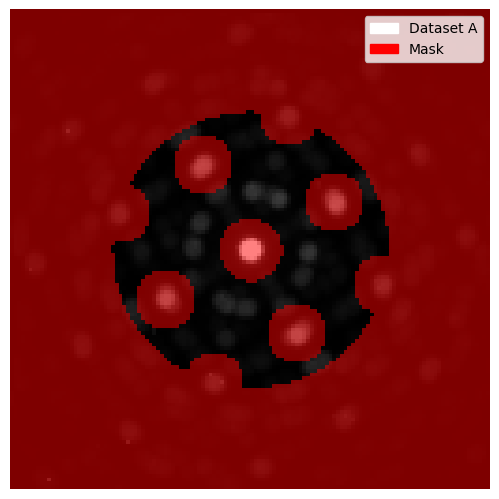

In [7]:
diffmask = union_mask([mask for (_, mask) in s.metadata.Preprocessing.Masks.Diffraction])
hs.plot.plot_images([maximums, diffmask*1.0], overlay=True, alphas=[1, 0.5], colors=['w', 'r'], axes_decor='off')

# First iteration
## Run SVD decomposition

In [8]:
tic = time.time()   
decomp = s.decomposition(
    normalize_poissonian_noise=True,
    algorithm='SVD',
    signal_mask=diffmask.data,
    return_info=True,
    copy=True
)
toc = time.time()
print(f'Finished decomposition. Elapsed time: {toc - tic} seconds')
s.learning_results.save(filepath.with_name(f'{filepath.stem}_SVD1'))

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None
Finished decomposition. Elapsed time: 384.85329842567444 seconds


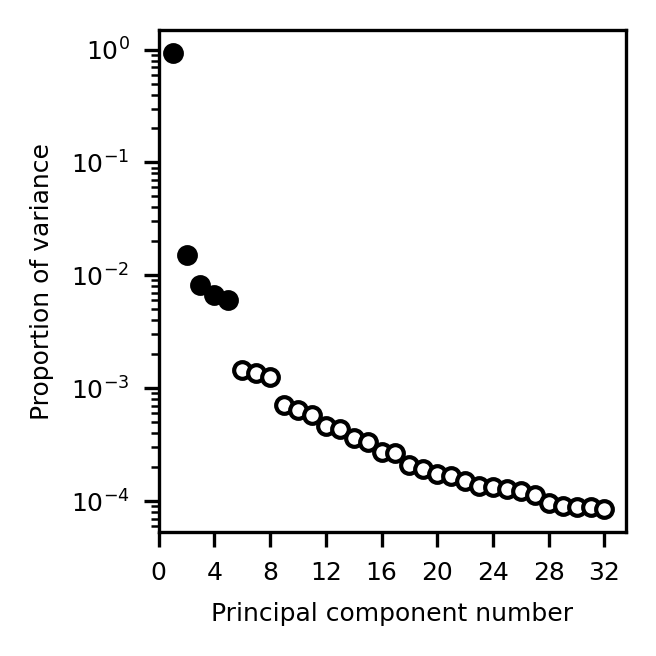

In [9]:
threshold = 5 #where the estimated threshold in the explained variance is - tune!
SMALL_SIZE = 6
MEDIUM_SIZE = 8
LARGE_SIZE = 10
with mpl.rc_context({
    'font.size': SMALL_SIZE, 
    'axes.titlesize': SMALL_SIZE,
    'axes.labelsize': MEDIUM_SIZE,
    'xtick.labelsize': SMALL_SIZE,
    'ytick.labelsize': SMALL_SIZE,
    'legend.fontsize': SMALL_SIZE,
    'figure.titlesize': LARGE_SIZE
}):
    markersize = 4 #Marker size for the plot
    dpi=300 #DPI
    figwidth = 468/3 #figure size in points
    pt2in = 0.01389 #conversion from points to inches
    figsize = (figwidth*pt2in, figwidth*pt2in) #Figuresize in inches
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    s.plot_explained_variance_ratio(n=32,
                                    threshold=threshold,
                                    xaxis_type='number',
                                    xaxis_labeling='ordinal',
                                    signal_fmt={'marker': 'o', 'color': 'k', 'markerfacecolor': 'k', 'lw': 0, 'ms':markersize},
                                    noise_fmt={'marker':'o', 'color': 'k', 'markerfacecolor': 'w', 'lw': 0, 'ms':markersize},
                                    fig=fig,
                                    ax=ax
                                   )
    ax.set_title('')
    ax.set_xlim(0)
    plt.tight_layout()
    fig.savefig(filepath.with_name(f'{filepath.stem}_SVD1.png'), dpi=dpi)

## Run first NMF decomposition

In [10]:
s = hs.load(str(filepath), lazy=False) #Reload data without any decomposition results
s.change_dtype('float32')

output_dimension = 5 #The number of components to allow
tic = time.time()
decomp = s.decomposition(
    normalize_poissonian_noise=True,
    algorithm='NMF',
    output_dimension=output_dimension,
    signal_mask=diffmask,
    return_info=True,
    init='nndsvd',
    max_iter=10000
)
toc = time.time()
print(f'Finished decomposition. Elapsed time: {toc - tic} seconds')
print(f'Decoposition parameters: {decomp}')
print(f'Decomposition reconstruction error: {decomp.reconstruction_err_}')
print(f'Decomposition number of iterations: {decomp.n_iter_}')

#Save the decomposition results
s.learning_results.save(filepath.with_name(f'{filepath.stem}_NMF1'), overwrite=True)

#Save the factors and loadings individually as well
factors = s.get_decomposition_factors()
loadings = s.get_decomposition_loadings()
if decomp is not None:
    factors.metadata.add_dictionary({'Decomposition': decomp.__dict__})
    loadings.metadata.add_dictionary({'Decomposition': decomp.__dict__})
factors.save(filepath.with_name(f'{filepath.stem}_NMF1_{output_dimension}_factors.hspy'), overwrite=True)
loadings.save(filepath.with_name(f'{filepath.stem}_NMF1_{output_dimension}_loadings.hspy'), overwrite=True)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=NMF
  output_dimension=5
  centre=None
scikit-learn estimator:
NMF(init='nndsvd', max_iter=10000, n_components=5)
Finished decomposition. Elapsed time: 8697.507939577103 seconds
Decoposition parameters: NMF(init='nndsvd', max_iter=10000, n_components=5)
Decomposition reconstruction error: 0.16367159549807625
Decomposition number of iterations: 8163


[<Axes: title={'center': ' (0,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <Axes: title={'center': ' (1,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <Axes: title={'center': ' (2,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <Axes: title={'center': ' (3,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <Axes: title={'center': ' (4,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>]

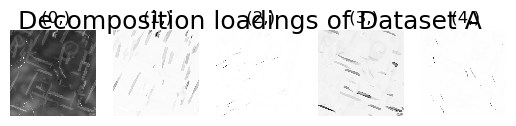

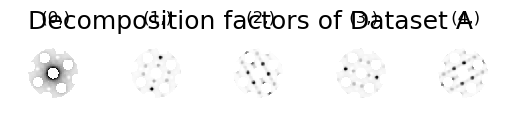

In [11]:
hs.plot.plot_images(loadings, per_row=output_dimension, cmap='gray_r', axes_decor='off', colorbar=None)
hs.plot.plot_images(factors, per_row=output_dimension, cmap='gray_r', norm='symlog', axes_decor='off', colorbar=None)

### Estimate thresholds for phase map
Manually identify the components corresponding to each phase in the previous plots and assign them to each phase in the phase dictionary

In [12]:
phases['T1']['components'] = (1, 3)
phases['theta_100']['components'] = (2, 4)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen
skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen
skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen
skimage.filters.thresholding.threshold_isodata
skimage.

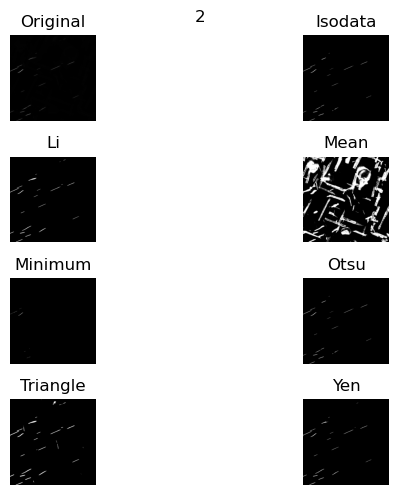

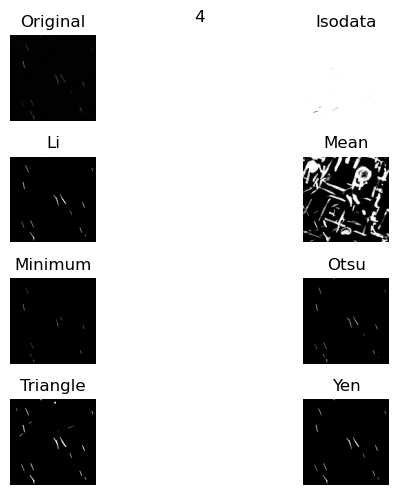

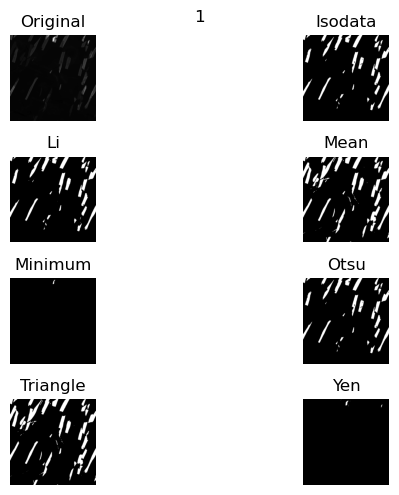

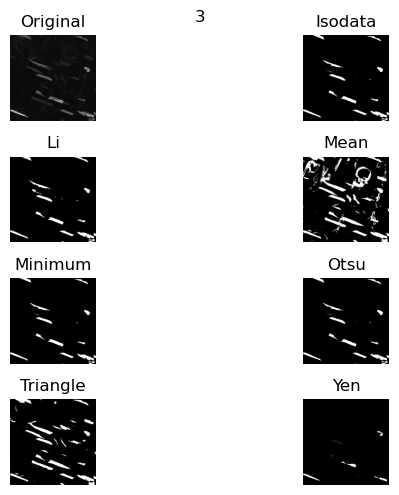

In [13]:
for phase in phases:
    for component in phases[phase]['components']:
        estimate_threshold(loadings, component)

In [14]:
phases['T1']['thresholds'].update({component: estimate_threshold(loadings, component, threshold_triangle) for component in phases['T1']['components']})
phases['theta_100']['thresholds'].update({component: estimate_threshold(loadings, component, threshold_li) for component in phases['theta_100']['components']})

In [15]:
phases

{'theta_100': {'value': 1.0,
  'components': (2, 4),
  'thresholds': {2: 0.008118947, 4: 0.007274865}},
 'theta_001': {'value': 2.0, 'components': (), 'thresholds': {}},
 'T1': {'value': 3.0,
  'components': (1, 3),
  'thresholds': {1: 0.0017684079, 3: 0.002026808}}}

### Apply thresholds and make phase maps

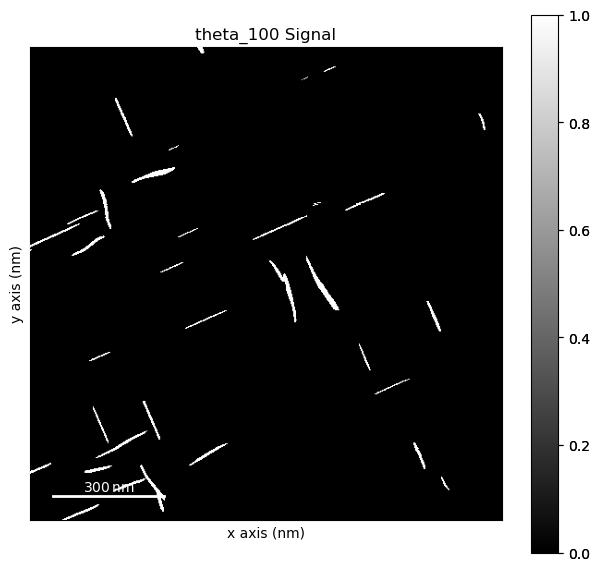

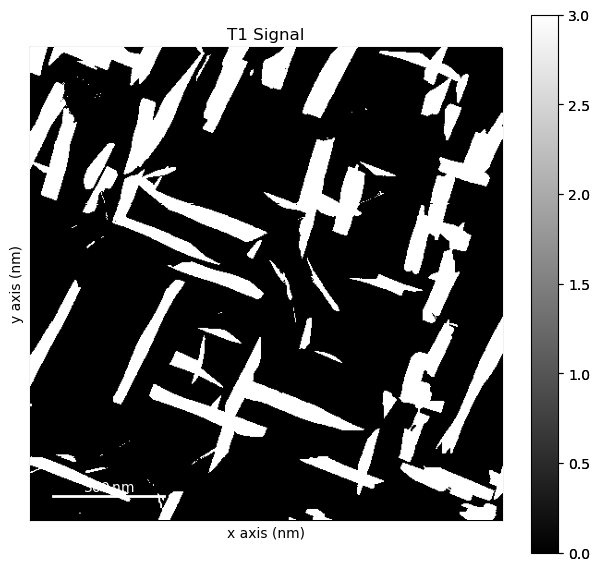

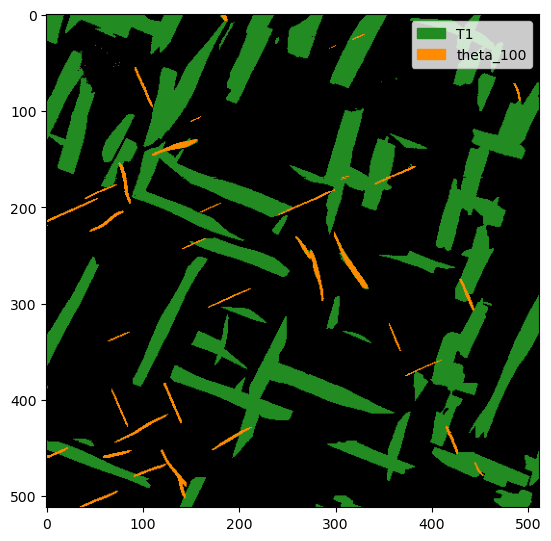

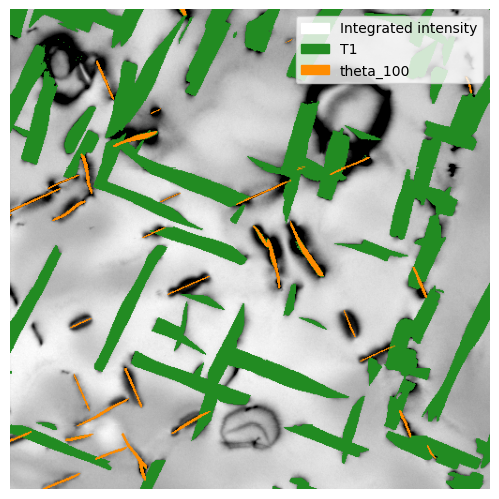

In [16]:
#Create mask signals
theta_100_mask = hs.signals.Signal2D(np.zeros(s.axes_manager.navigation_shape, dtype=bool))
T1_mask = hs.signals.Signal2D(np.zeros(s.axes_manager.navigation_shape, dtype=bool))
for ax_no, ax in enumerate(s.axes_manager.navigation_axes):
    for mask in [T1_mask, theta_100_mask]:
        mask.axes_manager[ax_no].name = s.axes_manager[ax].name
        mask.axes_manager[ax_no].scale = s.axes_manager[ax].scale
        mask.axes_manager[ax_no].units = s.axes_manager[ax].units
        mask.axes_manager[ax_no].offset = s.axes_manager[ax].offset
        
#Set mask data for theta_100 
for component in phases['theta_100']['components']:
    theta_100_mask += loadings.inav[component]>=phases['theta_100']['thresholds'][component]
theta_100_mask.metadata.General.title = 'theta_100'
theta_100 = theta_100_mask * phases['theta_100']['value']
theta_100.plot()

#Set mask data for T1
for component in phases['T1']['components']:
    T1_mask += loadings.inav[component]>=phases['T1']['thresholds'][component]
T1_mask.metadata.General.title = 'T1'
T1 = T1_mask * phases['T1']['value']
T1.plot()

hs.plot.plot_images([T1, theta_100], overlay=True, colors=[colors[-2], colors[-4]])

if True:
    theta_100.save(filepath.with_name(f'{filepath.stem}_theta_100.hspy'), overwrite=True)
    T1.save(filepath.with_name(f'{filepath.stem}_T1.hspy'), overwrite=True)

    [s.metadata.add_dictionary({'Preprocessing': {'Masks': {'Navigation': {mask.metadata.General.title: mask}}}}) for mask in [theta_100_mask, T1_mask]]

    hs.plot.plot_images([vbf, T1, theta_100], overlay=True, alphas=[1, 1, 1], colors=['w', colors[3], colors[1]], axes_decor='off')
    fig = plt.gcf()
    fig.savefig(filepath.with_name(f'{filepath.stem}_T1_theta100.png'))

# 2nd iteration

### get the new masks

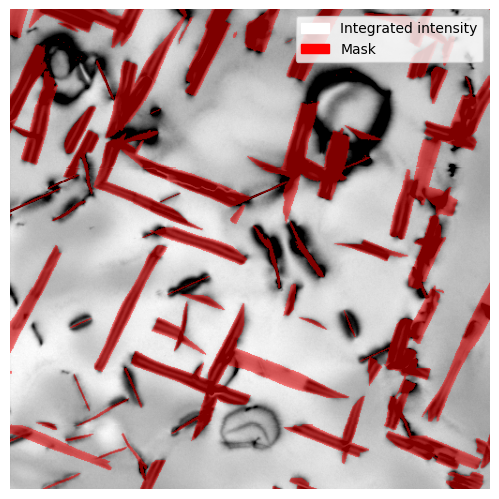

In [17]:
navmask = union_mask([mask for (_, mask) in s.metadata.Preprocessing.Masks.Navigation])
hs.plot.plot_images([vbf, navmask*1.0], overlay=True, alphas=[1, 0.5], colors=['w', 'r'], axes_decor='off')
fig = plt.gcf()
fig.savefig(filepath.with_name(f'{filepath.stem}_NMF2_navmask.png'))

## SVD

In [18]:
s = hs.load(str(filepath), lazy=False) #Reload data without any decomposition results
s.change_dtype('float32')

tic = time.time()
decomp = s.decomposition(
    normalize_poissonian_noise=True,
    algorithm='SVD',
    signal_mask=diffmask.data,
    navigation_mask=navmask.data.T,
    return_info=True
)
toc = time.time()
print(f'Finished decomposition. Elapsed time: {toc - tic} seconds')
s.learning_results.save(filepath.with_name(f'{filepath.stem}_SVD2'), overwrite=True)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None
Finished decomposition. Elapsed time: 398.22979640960693 seconds


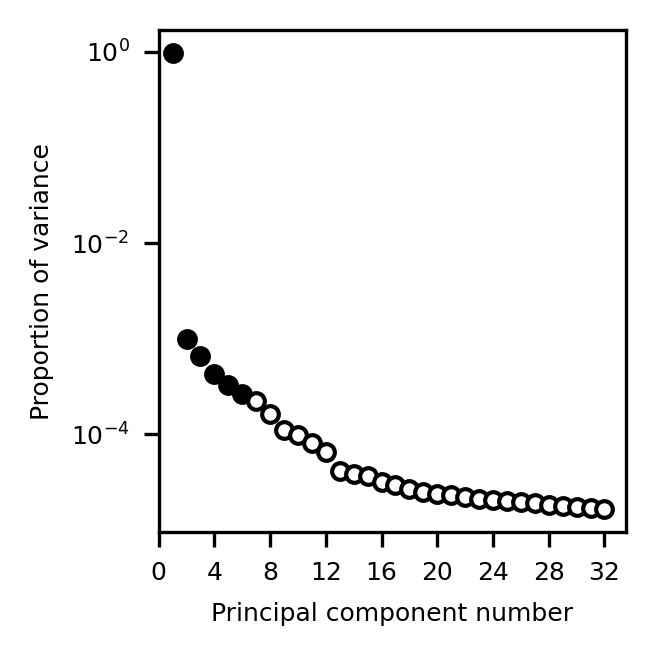

In [19]:
threshold = 6 #where the estimated threshold in the explained variance is - tune!
SMALL_SIZE = 6
MEDIUM_SIZE = 8
LARGE_SIZE = 10
with mpl.rc_context({
    'font.size': SMALL_SIZE, 
    'axes.titlesize': SMALL_SIZE,
    'axes.labelsize': MEDIUM_SIZE,
    'xtick.labelsize': SMALL_SIZE,
    'ytick.labelsize': SMALL_SIZE,
    'legend.fontsize': SMALL_SIZE,
    'figure.titlesize': LARGE_SIZE
}):
    markersize = 4 #Marker size for the plot
    dpi=300 #DPI
    figwidth = 468/3 #figure size in points
    pt2in = 0.01389 #conversion from points to inches
    figsize = (figwidth*pt2in, figwidth*pt2in) #Figuresize in inches
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    s.plot_explained_variance_ratio(n=32,
                                    threshold=threshold,
                                    xaxis_type='number',
                                    xaxis_labeling='ordinal',
                                    signal_fmt={'marker': 'o', 'color': 'k', 'markerfacecolor': 'k', 'lw': 0, 'ms':markersize},
                                    noise_fmt={'marker':'o', 'color': 'k', 'markerfacecolor': 'w', 'lw': 0, 'ms':markersize},
                                    fig=fig,
                                    ax=ax
                                   )
    ax.set_title('')
    ax.set_xlim(0)
    plt.tight_layout()
    fig.savefig(filepath.with_name(f'{filepath.stem}_SVD2.png'), dpi=dpi)

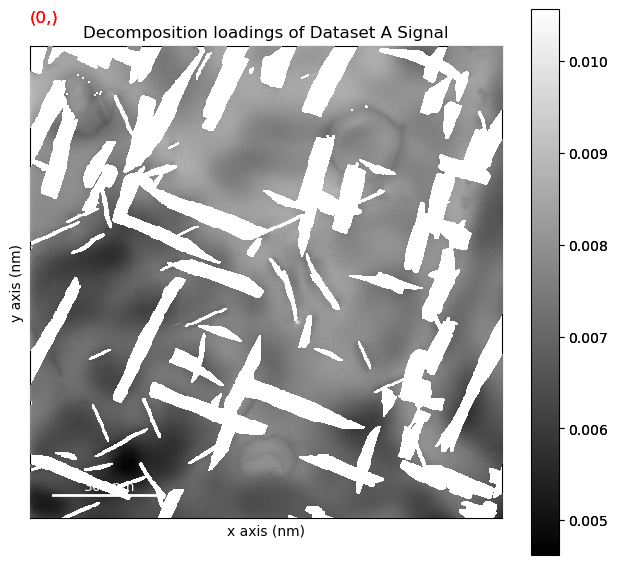

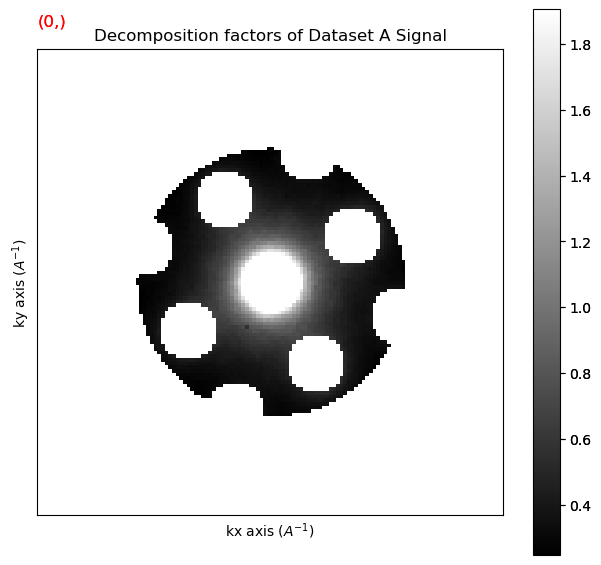

In [20]:
s.plot_decomposition_results()

### NMF

In [21]:
s = hs.load(str(filepath), lazy=False) #Reload data without any decomposition results
s.change_dtype('float32')

output_dimension = 6 #The number of components to allow
tic = time.time()
decomp = s.decomposition(
    normalize_poissonian_noise=True,
    algorithm='NMF',
    output_dimension=output_dimension,
    signal_mask=diffmask,
    navigation_mask=navmask.data.T,
    return_info=True,
    init='nndsvd',
    max_iter=10000
)
toc = time.time()
print(f'Finished decomposition. Elapsed time: {toc - tic} seconds')
print(f'Decoposition parameters: {decomp}')
print(f'Decomposition reconstruction error: {decomp.reconstruction_err_}')
print(f'Decomposition number of iterations: {decomp.n_iter_}')

#Save the decomposition results
s.learning_results.save(filepath.with_name(f'{filepath.stem}_NMF2'), overwrite=True)

#Save the factors and loadings individually as well
factors = s.get_decomposition_factors()
loadings = s.get_decomposition_loadings()
if decomp is not None:
    factors.metadata.add_dictionary({'Decomposition': decomp.__dict__})
    loadings.metadata.add_dictionary({'Decomposition': decomp.__dict__})
factors.save(filepath.with_name(f'{filepath.stem}_NMF2_{output_dimension}_factors.hspy'), overwrite=True)
loadings.save(filepath.with_name(f'{filepath.stem}_NMF2_{output_dimension}_loadings.hspy'), overwrite=True)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=NMF
  output_dimension=6
  centre=None
scikit-learn estimator:
NMF(init='nndsvd', max_iter=10000, n_components=6)
Finished decomposition. Elapsed time: 5442.657974481583 seconds
Decoposition parameters: NMF(init='nndsvd', max_iter=10000, n_components=6)
Decomposition reconstruction error: 0.13017277867945978
Decomposition number of iterations: 9039


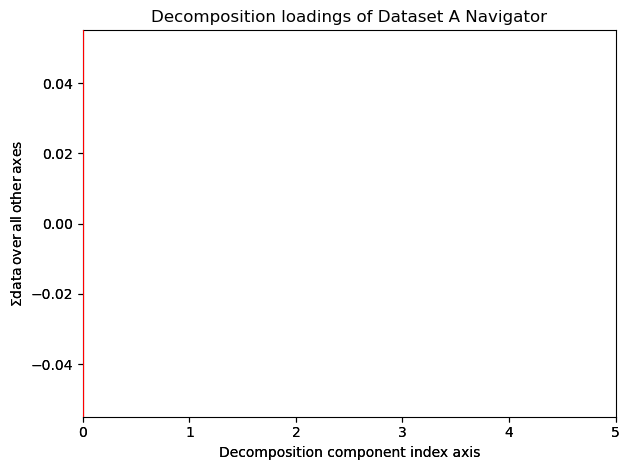

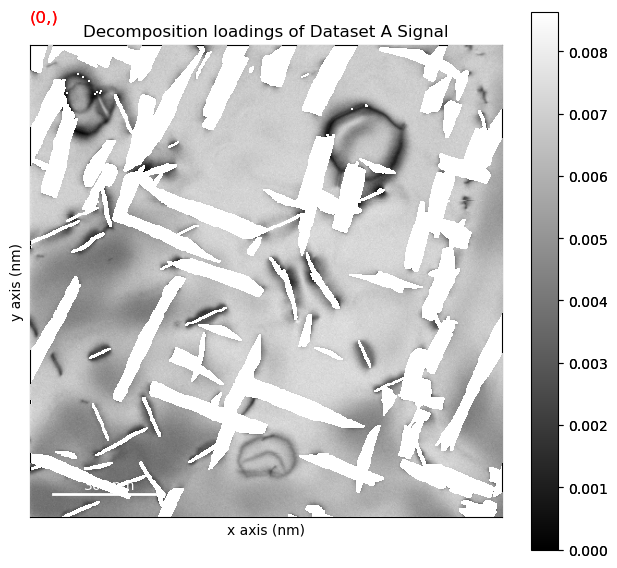

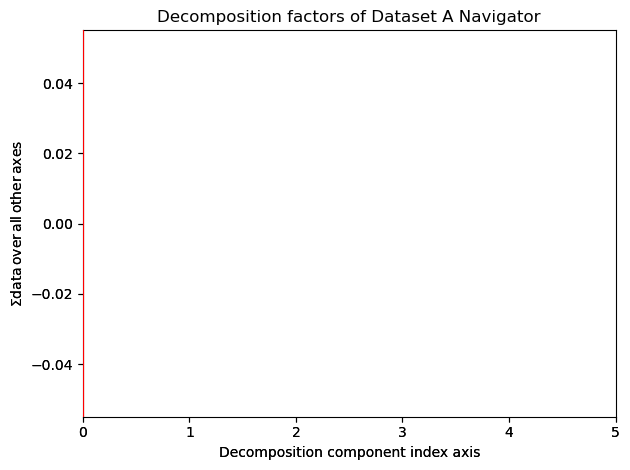

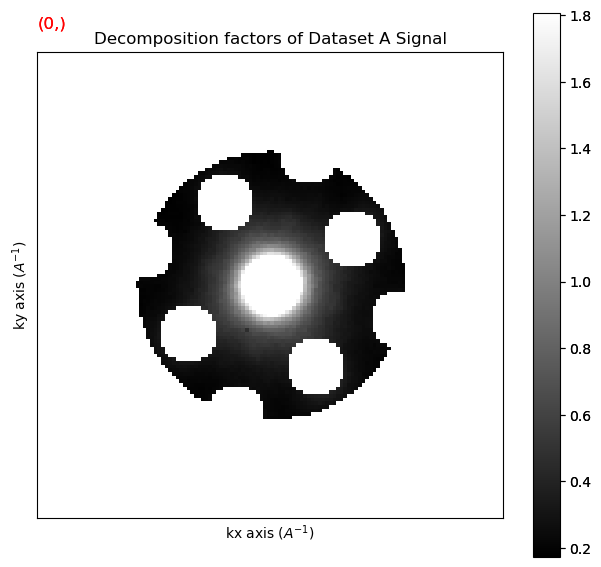

In [22]:
hs.plot.plot_signals([loadings, factors])

Manually identify the component corresponding to the $\theta_{001}$ from the previous plot and assign it to the phase in the phase dict

In [23]:
phases['theta_001']['components'] = (4,)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


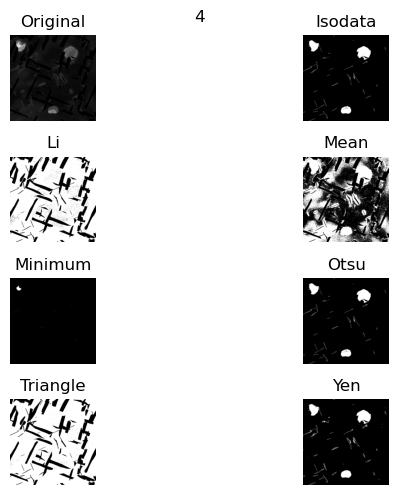

In [24]:
estimate_threshold(loadings, 4)

In [25]:
phases['theta_001']['thresholds'].update({component: estimate_threshold(loadings, component, threshold_isodata) for component in phases['theta_001']['components']})

In [26]:
phases

{'theta_100': {'value': 1.0,
  'components': (2, 4),
  'thresholds': {2: 0.008118947, 4: 0.007274865}},
 'theta_001': {'value': 2.0,
  'components': (4,),
  'thresholds': {4: 0.004178888248134172}},
 'T1': {'value': 3.0,
  'components': (1, 3),
  'thresholds': {1: 0.0017684079, 3: 0.002026808}}}

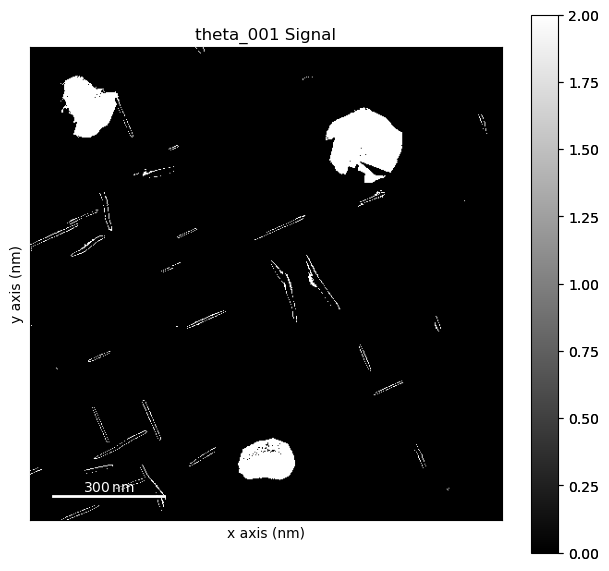

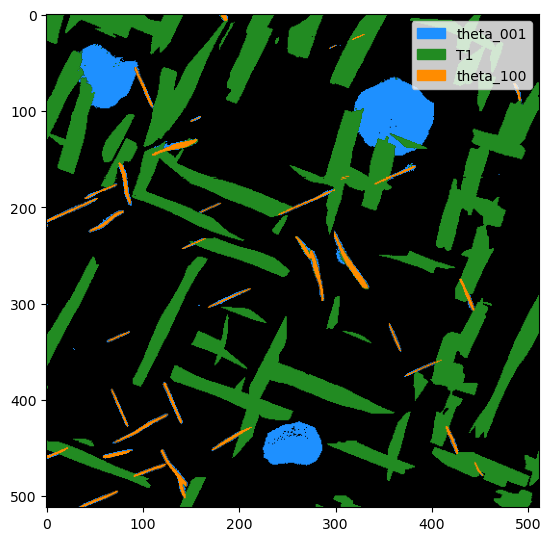

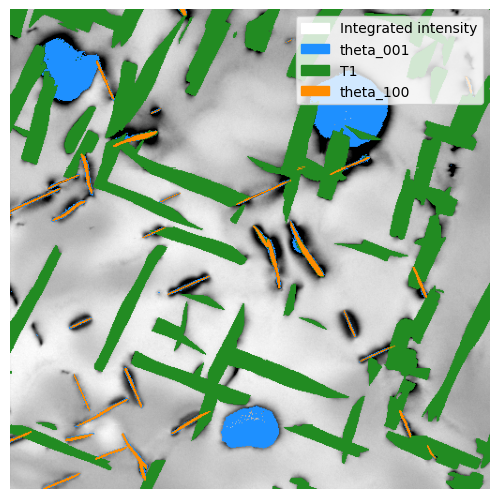

In [27]:
#Create mask signals
theta_001_mask = hs.signals.Signal2D(np.zeros(s.axes_manager.navigation_shape, dtype=bool))
for ax_no, ax in enumerate(s.axes_manager.navigation_axes):
    theta_001_mask.axes_manager[ax_no].name = s.axes_manager[ax].name
    theta_001_mask.axes_manager[ax_no].scale = s.axes_manager[ax].scale
    theta_001_mask.axes_manager[ax_no].units = s.axes_manager[ax].units
    theta_001_mask.axes_manager[ax_no].offset = s.axes_manager[ax].offset
        
#Set mask data for theta_100 
for component in phases['theta_001']['components']:
    theta_001_mask += loadings.inav[component]>=phases['theta_001']['thresholds'][component]
theta_001_mask.metadata.General.title = 'theta_001'
theta_001 = theta_001_mask * phases['theta_001']['value']
theta_001.plot()

hs.plot.plot_images([theta_001, T1, theta_100], overlay=True, colors=[colors[-3], colors[-2], colors[-4]])

if True:
    theta_001.save(filepath.with_name(f'{filepath.stem}_theta_001.hspy'), overwrite=True)

    s.metadata.add_dictionary({'Preprocessing': {'Masks': {'Navigation': {theta_001_mask.metadata.General.title: theta_001_mask}}}})

    hs.plot.plot_images([vbf, theta_001, T1, theta_100], overlay=True, alphas=[1, 1, 1, 1], colors=['w', colors[-3], colors[-2], colors[-4]], axes_decor='off')
    fig = plt.gcf()
    fig.savefig(filepath.with_name(f'{filepath.stem}_theta001_T1_theta100.png'))

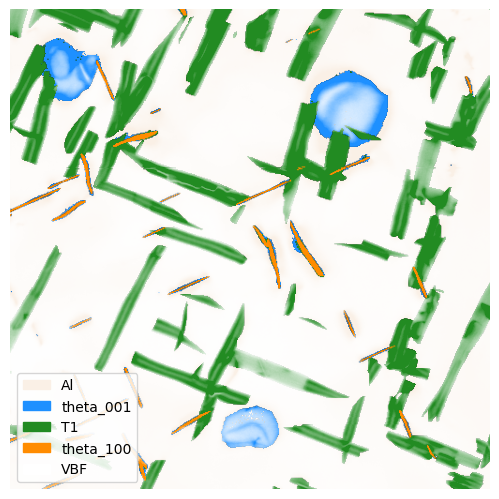

In [28]:
matrix = hs.signals.Signal2D(np.ones(s.axes_manager.navigation_shape, dtype='uint8'))
for ax_no, ax in enumerate(s.axes_manager.navigation_axes):
    matrix.axes_manager[ax_no].name = s.axes_manager[ax].name
    matrix.axes_manager[ax_no].scale = s.axes_manager[ax].scale
    matrix.axes_manager[ax_no].units = s.axes_manager[ax].units
    matrix.axes_manager[ax_no].offset = s.axes_manager[ax].offset
matrix.metadata.General.title = 'Al'

matrix.data[theta_001_mask] = 0
matrix.data[theta_100_mask] = 0
matrix.data[T1_mask] = 0


vbf.metadata.General.title = 'VBF'

if True:
    matrix.save(filepath.with_name(f'{filepath.stem}_matrix.hspy'), overwrite=True)

    s.metadata.add_dictionary({'Preprocessing': {'Masks': {'Navigation': {matrix.metadata.General.title: matrix}}}})

    hs.plot.plot_images([matrix, theta_001, T1, theta_100, vbf], overlay=True, alphas=[1, 1, 1, 1, 1], colors=[colors[0], colors[-3], colors[-2], colors[-4], 'w'], axes_decor='off', legend_loc='lower left')
    fig = plt.gcf()
    fig.savefig(filepath.with_name(f'{filepath.stem}_matrix_theta001_T1_theta100.png'))

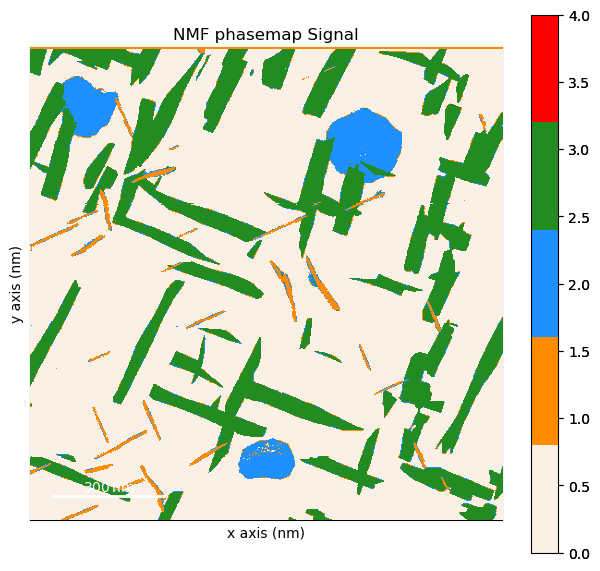

In [29]:
phasemap = hs.signals.Signal2D(np.zeros(s.axes_manager.navigation_shape))
phasemap.data[theta_001_mask] = phases['theta_001']['value']
phasemap.data[T1_mask] = phases['T1']['value']
phasemap.data[theta_100_mask] = phases['theta_100']['value']
phasemap.data[matrix] = 1

for ax_no, ax in enumerate(s.axes_manager.navigation_axes):
    phasemap.axes_manager[ax_no].name = s.axes_manager[ax].name
    phasemap.axes_manager[ax_no].scale = s.axes_manager[ax].scale
    phasemap.axes_manager[ax_no].units = s.axes_manager[ax].units
    phasemap.axes_manager[ax_no].offset = s.axes_manager[ax].offset
phasemap.metadata.General.title = 'NMF phasemap'

phasemap.plot(cmap=cmap, vmax=4)

phasemap.save(filepath.with_name(f'{filepath.stem}_phasemap.hspy'), overwrite=True)

In [30]:
s.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── Diffraction
│       │       ├── camera_length = 23.036135801743175
│       │       └── exposure_time = 10
│       ├── beam_energy = 200
│       ├── rocking_angle = 1.04
│       ├── rocking_frequency = 100
│       └── scan_rotation = 0
├── General
│   ├── FileIO
│   │   ├── 0
│   │   │   ├── hyperspy_version = 1.7.3
│   │   │   ├── io_plugin = hyperspy.io_plugins.hspy
│   │   │   ├── operation = save
│   │   │   └── timestamp = 2023-05-28T12:18:54.719021+02:00
│   │   ├── 1
│   │   │   ├── hyperspy_version = 1.7.3
│   │   │   ├── io_plugin = hyperspy.io_plugins.hspy
│   │   │   ├── operation = load
│   │   │   └── timestamp = 2023-05-28T12:32:34.660832+02:00
│   │   ├── 2
│   │   │   ├── hyperspy_version = 1.7.3
│   │   │   ├── io_plugin = hyperspy.io_plugins.hspy
│   │   │   ├── operation = save
│   │   │   └── timestamp = 2023-05-28T12:44:12.493160+02:00
│   │   └── 3
│   │       ├── hyperspy_version = 1.7.3
│   │       ├── io_plugin = hyperspy.io_plugins.hspy
│   │       ├── operation = load
│   │       └── timestamp = 2023-07-04T02:04:04.854343+02:00
│   └── title = Dataset A
├── Preprocessing
│   ├── Centering
│   │   ├── COM = <DPCSignal2D, title: , dimensions: (2|512, 512)>
│   │   ├── COM_mask
│   │   │   ├── r = 12.5
│   │   │   ├── x = 127
│   │   │   └── y = 126
│   │   ├── Shifts = <BeamShift, title: , dimensions: (512, 512|2)>
│   │   └── shift_estimate_mask = <BaseSignal, title: , dimensions: (512, 512|)>
│   └── Masks
│       ├── Diffraction
│       │   ├── cutoff = <Signal2D, title: <7.001e-01 $A^{-1}$ mask, dimensions: (|128, 128)>
│       │   ├── direct_beam = <Signal2D, title: >1.595e-01 $A^{-1}$ mask, dimensions: (|128, 128)>
│       │   └── reflections = <Signal2D, title: Reflection mask, dimensions: (|128, 128)>
│       └── Navigation
│           ├── Al = <Signal2D, title: Al, dimensions: (|512, 512)>
│           └── theta_001 = <Signal2D, title: theta_001, dimensions: (|512, 512)>
└── Signal
    └── signal_type = electron_diffraction

# Dataset B

## Load and prepare data

In [31]:
filepath = Path(r'/media/emilc/Data21/Data/PhaseMapping/Dataset B/datasetB_preprocessed.hspy')

[<Axes: title={'center': 'Integrated intensity'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>,
 <Axes: title={'center': 'Dataset B'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>]

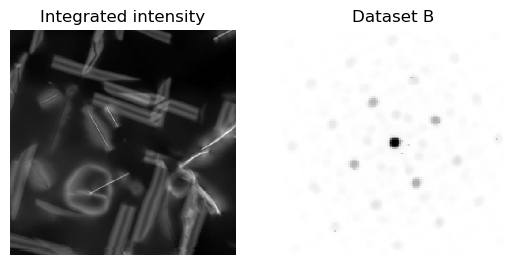

In [32]:
s = hs.load(str(filepath), lazy=False)
s.change_dtype('float32')
vbf = s.get_integrated_intensity(hs.roi.CircleROI(0.0, 0.0, 0.1))
maximums = s.max(axis=[0, 1])
try:
    vbf.compute()
    maximums.compute()
except AttributeError:
    pass
hs.plot.plot_images([vbf, maximums], norm='symlog', axes_decor='off', colorbar=None, cmap='gray_r')

In [33]:
s.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── Diffraction
│       │       ├── camera_length = 23.255992877263527
│       │       └── exposure_time = 10
│       ├── beam_energy = 200
│       ├── rocking_angle = 1.0
│       ├── rocking_frequency = 100
│       └── scan_rotation = 0
├── General
│   ├── FileIO
│   │   ├── 0
│   │   │   ├── hyperspy_version = 1.7.3
│   │   │   ├── io_plugin = hyperspy.io_plugins.hspy
│   │   │   ├── operation = save
│   │   │   └── timestamp = 2023-05-28T13:50:47.670921+02:00
│   │   ├── 1
│   │   │   ├── hyperspy_version = 1.7.3
│   │   │   ├── io_plugin = hyperspy.io_plugins.hspy
│   │   │   ├── operation = load
│   │   │   └── timestamp = 2023-05-28T14:02:08.752018+02:00
│   │   ├── 2
│   │   │   ├── hyperspy_version = 1.7.3
│   │   │   ├── io_plugin = hyperspy.io_plugins.hspy
│   │   │   ├── operation = save
│   │   │   └── timestamp = 2023-05-28T14:13:26.013839+02:00
│   │   └── 3
│   │       ├── hyperspy_version = 1.7.3
│   │       ├── io_plugin = hyperspy.io_plugins.hspy
│   │       ├── operation = load
│   │       └── timestamp = 2023-07-04T03:37:56.944545+02:00
│   └── title = Dataset B
├── Preprocessing
│   ├── Centering
│   │   ├── COM = <DPCSignal2D, title: , dimensions: (2|512, 512)>
│   │   ├── COM_mask
│   │   │   ├── r = 12.5
│   │   │   ├── x = 125
│   │   │   └── y = 125
│   │   ├── Shifts = <BeamShift, title: , dimensions: (512, 512|2)>
│   │   └── shift_estimate_mask = <BaseSignal, title: , dimensions: (512, 512|)>
│   └── Masks
│       └── Diffraction
│           ├── cutoff = <Signal2D, title: <7.001e-01 $A^{-1}$ mask, dimensions: (|128, 128)>
│           ├── direct_beam = <Signal2D, title: >1.595e-01 $A^{-1}$ mask, dimensions: (|128, 128)>
│           └── reflections = <Signal2D, title: Reflection mask, dimensions: (|128, 128)>
└── Signal
    └── signal_type = electron_diffraction

## Get the pre-made masks from the metadata (see preprocessing notebook for details)

[<Axes: >]

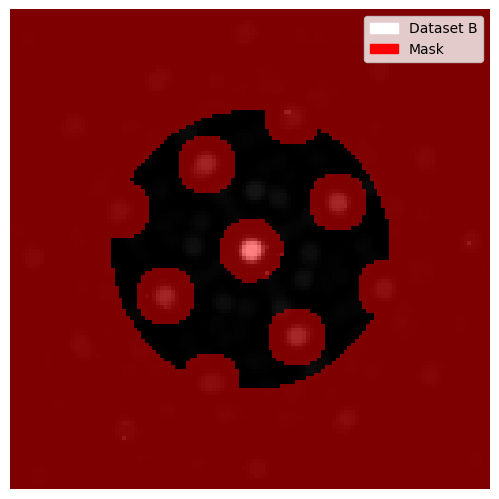

In [34]:
diffmask = union_mask([mask for (_, mask) in s.metadata.Preprocessing.Masks.Diffraction])
hs.plot.plot_images([maximums, diffmask*1.0], overlay=True, alphas=[1, 0.5], colors=['w', 'r'], axes_decor='off')

# First iteration
## Run SVD decomposition

In [35]:
tic = time.time()   
decomp = s.decomposition(
    normalize_poissonian_noise=True,
    algorithm='SVD',
    signal_mask=diffmask.data,
    return_info=True,
    copy=True
)
toc = time.time()
print(f'Finished decomposition. Elapsed time: {toc - tic} seconds')
s.learning_results.save(filepath.with_name(f'{filepath.stem}_SVD1'))

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None
Finished decomposition. Elapsed time: 501.917519569397 seconds


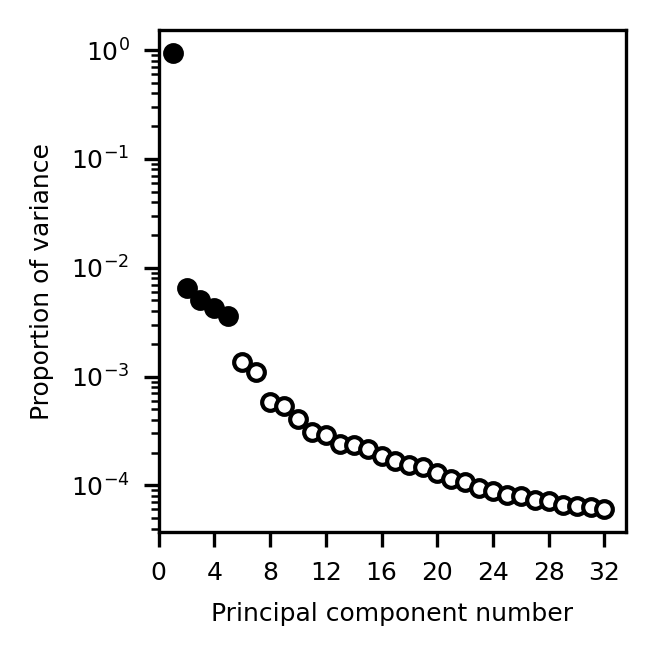

In [36]:
threshold = 5 #where the estimated threshold in the explained variance is - tune!
SMALL_SIZE = 6
MEDIUM_SIZE = 8
LARGE_SIZE = 10
with mpl.rc_context({
    'font.size': SMALL_SIZE, 
    'axes.titlesize': SMALL_SIZE,
    'axes.labelsize': MEDIUM_SIZE,
    'xtick.labelsize': SMALL_SIZE,
    'ytick.labelsize': SMALL_SIZE,
    'legend.fontsize': SMALL_SIZE,
    'figure.titlesize': LARGE_SIZE
}):
    markersize = 4 #Marker size for the plot
    dpi=300 #DPI
    figwidth = 468/3 #figure size in points
    pt2in = 0.01389 #conversion from points to inches
    figsize = (figwidth*pt2in, figwidth*pt2in) #Figuresize in inches
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    s.plot_explained_variance_ratio(n=32,
                                    threshold=threshold,
                                    xaxis_type='number',
                                    xaxis_labeling='ordinal',
                                    signal_fmt={'marker': 'o', 'color': 'k', 'markerfacecolor': 'k', 'lw': 0, 'ms':markersize},
                                    noise_fmt={'marker':'o', 'color': 'k', 'markerfacecolor': 'w', 'lw': 0, 'ms':markersize},
                                    fig=fig,
                                    ax=ax
                                   )
    ax.set_title('')
    ax.set_xlim(0)
    plt.tight_layout()
    fig.savefig(filepath.with_name(f'{filepath.stem}_SVD1.png'), dpi=dpi)

In [37]:
phases = {
    'theta_100': {'value': 1.0, 'components': tuple(), 'thresholds': {}},
    'theta_001': {'value': 2.0, 'components': tuple(), 'thresholds': {}},
    'T1': {'value': 3.0, 'components': tuple(), 'thresholds': {}}
}


## Run first NMF decomposition

In [38]:
s = hs.load(str(filepath), lazy=False) #Reload data without any decomposition results
s.change_dtype('float32')

output_dimension = 5 #The number of components to allow
tic = time.time()
decomp = s.decomposition(
    normalize_poissonian_noise=True,
    algorithm='NMF',
    output_dimension=output_dimension,
    signal_mask=diffmask,
    return_info=True,
    init='nndsvd',
    max_iter=10000
)
toc = time.time()
print(f'Finished decomposition. Elapsed time: {toc - tic} seconds')
print(f'Decoposition parameters: {decomp}')
print(f'Decomposition reconstruction error: {decomp.reconstruction_err_}')
print(f'Decomposition number of iterations: {decomp.n_iter_}')

#Save the decomposition results
s.learning_results.save(filepath.with_name(f'{filepath.stem}_NMF1'), overwrite=True)

#Save the factors and loadings individually as well
factors = s.get_decomposition_factors()
loadings = s.get_decomposition_loadings()
if decomp is not None:
    factors.metadata.add_dictionary({'Decomposition': decomp.__dict__})
    loadings.metadata.add_dictionary({'Decomposition': decomp.__dict__})
factors.save(filepath.with_name(f'{filepath.stem}_NMF1_{output_dimension}_factors.hspy'), overwrite=True)
loadings.save(filepath.with_name(f'{filepath.stem}_NMF1_{output_dimension}_loadings.hspy'), overwrite=True)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=NMF
  output_dimension=5
  centre=None
scikit-learn estimator:
NMF(init='nndsvd', max_iter=10000, n_components=5)
Finished decomposition. Elapsed time: 5672.594741821289 seconds
Decoposition parameters: NMF(init='nndsvd', max_iter=10000, n_components=5)
Decomposition reconstruction error: 0.18755717200618574
Decomposition number of iterations: 5092


[<Axes: title={'center': ' (0,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <Axes: title={'center': ' (1,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <Axes: title={'center': ' (2,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <Axes: title={'center': ' (3,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <Axes: title={'center': ' (4,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>]

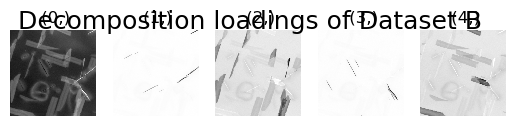

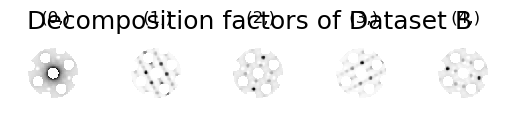

In [39]:
hs.plot.plot_images(loadings, per_row=output_dimension, cmap='gray_r', axes_decor='off', colorbar=None)
hs.plot.plot_images(factors, per_row=output_dimension, cmap='gray_r', norm='symlog', axes_decor='off', colorbar=None)

### Estimate thresholds for phase map

In [40]:
phases['T1']['components'] = (2, 4)
phases['theta_100']['components'] = (1, 3)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen
skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen
skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen
skimage.filters.thresholding.threshold_isodata
skimage.

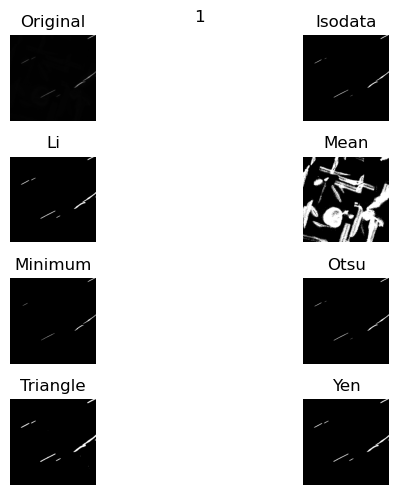

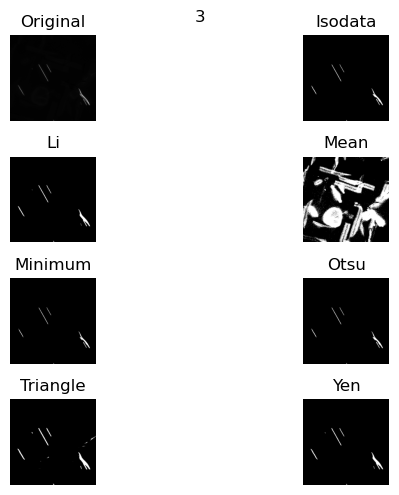

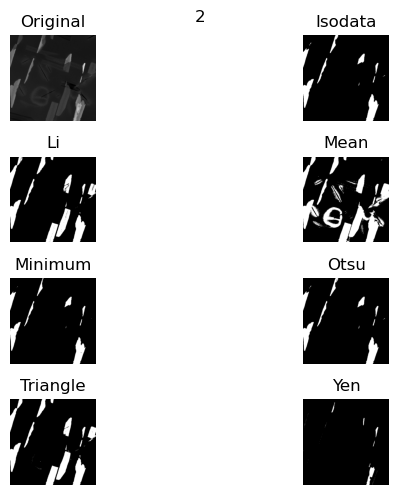

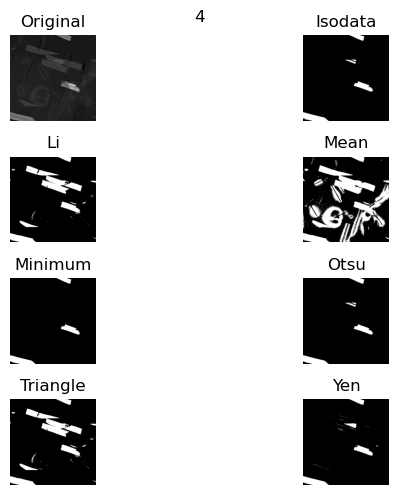

In [41]:
for phase in phases:
    for component in phases[phase]['components']:
        estimate_threshold(loadings, component)

In [42]:
phases['T1']['thresholds'].update({component: estimate_threshold(loadings, component, threshold_li) for component in phases['T1']['components']})
phases['theta_100']['thresholds'].update({component: estimate_threshold(loadings, component, threshold_li) for component in phases['theta_100']['components']})

In [43]:
phases

{'theta_100': {'value': 1.0,
  'components': (1, 3),
  'thresholds': {1: 0.006148654, 3: 0.005472423}},
 'theta_001': {'value': 2.0, 'components': (), 'thresholds': {}},
 'T1': {'value': 3.0,
  'components': (2, 4),
  'thresholds': {2: 0.0024120628, 4: 0.0022902328}}}

### Apply thresholds and make phase maps

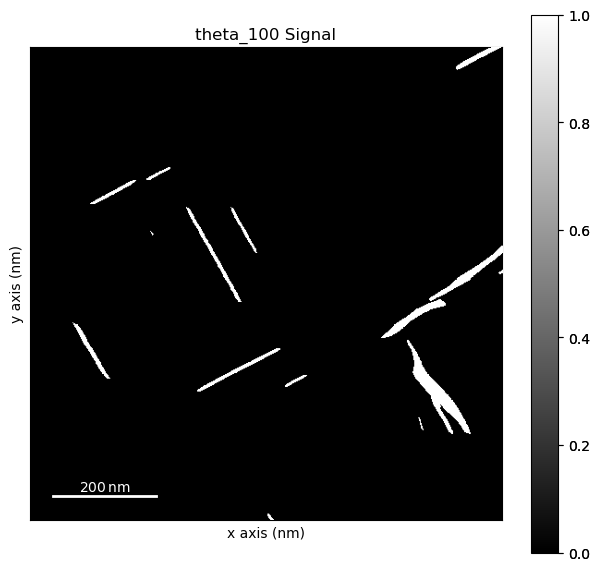

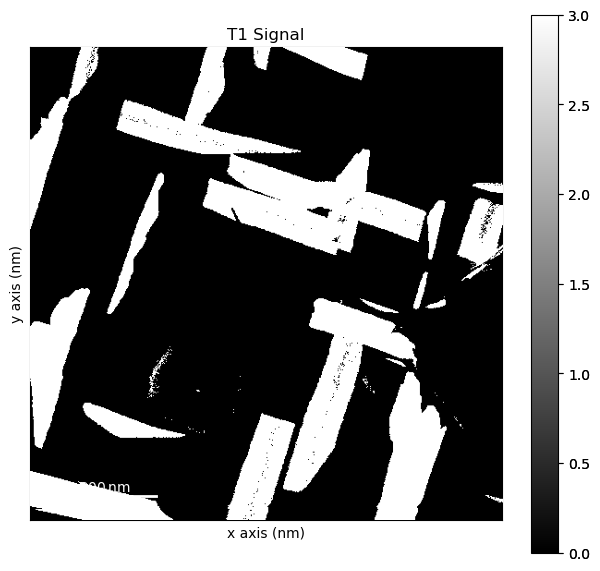

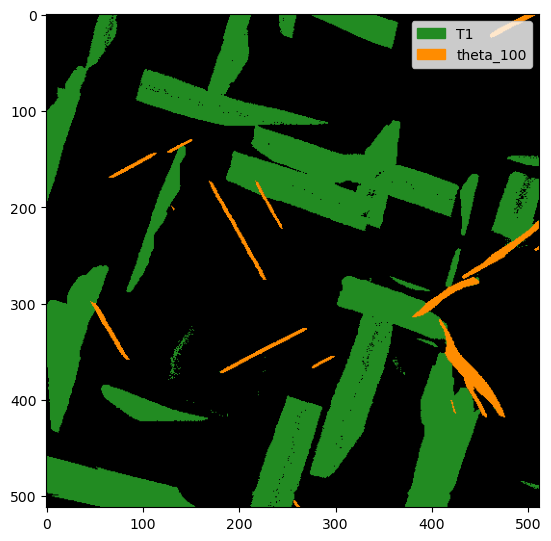

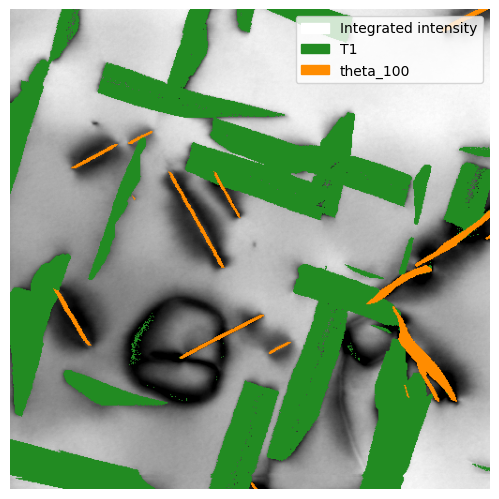

In [44]:
#Create mask signals
theta_100_mask = hs.signals.Signal2D(np.zeros(s.axes_manager.navigation_shape, dtype=bool))
T1_mask = hs.signals.Signal2D(np.zeros(s.axes_manager.navigation_shape, dtype=bool))
for ax_no, ax in enumerate(s.axes_manager.navigation_axes):
    for mask in [T1_mask, theta_100_mask]:
        mask.axes_manager[ax_no].name = s.axes_manager[ax].name
        mask.axes_manager[ax_no].scale = s.axes_manager[ax].scale
        mask.axes_manager[ax_no].units = s.axes_manager[ax].units
        mask.axes_manager[ax_no].offset = s.axes_manager[ax].offset
        
#Set mask data for theta_100 
for component in phases['theta_100']['components']:
    theta_100_mask += loadings.inav[component]>=phases['theta_100']['thresholds'][component]
theta_100_mask.metadata.General.title = 'theta_100'
theta_100 = theta_100_mask * phases['theta_100']['value']
theta_100.plot()

#Set mask data for T1
for component in phases['T1']['components']:
    T1_mask += loadings.inav[component]>=phases['T1']['thresholds'][component]
T1_mask.metadata.General.title = 'T1'
T1 = T1_mask * phases['T1']['value']
T1.plot()

hs.plot.plot_images([T1, theta_100], overlay=True, colors=[colors[-2], colors[-4]])

if True:
    theta_100.save(filepath.with_name(f'{filepath.stem}_theta_100.hspy'), overwrite=True)
    T1.save(filepath.with_name(f'{filepath.stem}_T1.hspy'), overwrite=True)

    [s.metadata.add_dictionary({'Preprocessing': {'Masks': {'Navigation': {mask.metadata.General.title: mask}}}}) for mask in [theta_100_mask, T1_mask]]

    hs.plot.plot_images([vbf, T1, theta_100], overlay=True, alphas=[1, 1, 1], colors=['w', colors[3], colors[1]], axes_decor='off')
    fig = plt.gcf()
    fig.savefig(filepath.with_name(f'{filepath.stem}_T1_theta100.png'))

# 2nd iteration

### get the new masks

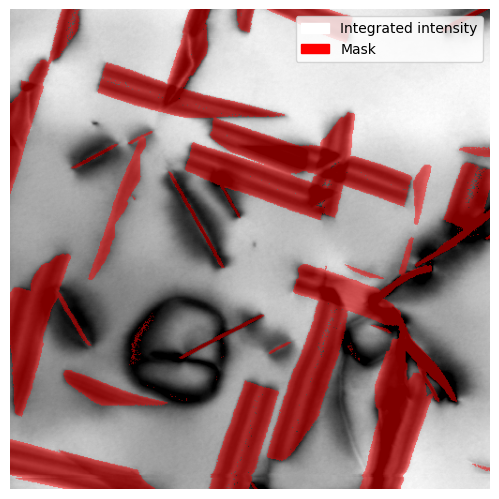

In [45]:
navmask = union_mask([mask for (_, mask) in s.metadata.Preprocessing.Masks.Navigation])
hs.plot.plot_images([vbf, navmask*1.0], overlay=True, alphas=[1, 0.5], colors=['w', 'r'], axes_decor='off')
fig = plt.gcf()
fig.savefig(filepath.with_name(f'{filepath.stem}_NMF2_navmask.png'))

## SVD

In [46]:
s = hs.load(str(filepath), lazy=False) #Reload data without any decomposition results
s.change_dtype('float32')

tic = time.time()
decomp = s.decomposition(
    normalize_poissonian_noise=True,
    algorithm='SVD',
    signal_mask=diffmask.data,
    navigation_mask=navmask.data.T,
    return_info=True
)
toc = time.time()
print(f'Finished decomposition. Elapsed time: {toc - tic} seconds')
s.learning_results.save(filepath.with_name(f'{filepath.stem}_SVD2'), overwrite=True)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None
Finished decomposition. Elapsed time: 347.94757604599 seconds


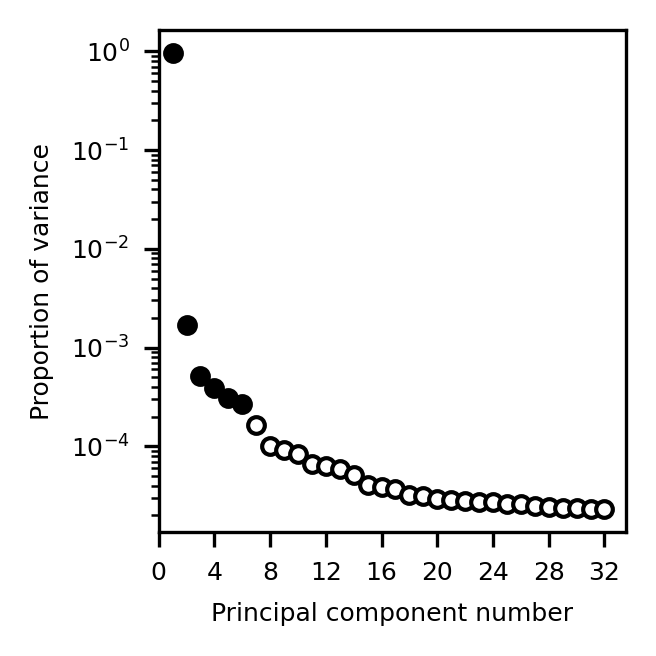

In [47]:
threshold = 6 #where the estimated threshold in the explained variance is - tune!
SMALL_SIZE = 6
MEDIUM_SIZE = 8
LARGE_SIZE = 10
with mpl.rc_context({
    'font.size': SMALL_SIZE, 
    'axes.titlesize': SMALL_SIZE,
    'axes.labelsize': MEDIUM_SIZE,
    'xtick.labelsize': SMALL_SIZE,
    'ytick.labelsize': SMALL_SIZE,
    'legend.fontsize': SMALL_SIZE,
    'figure.titlesize': LARGE_SIZE
}):
    markersize = 4 #Marker size for the plot
    dpi=300 #DPI
    figwidth = 468/3 #figure size in points
    pt2in = 0.01389 #conversion from points to inches
    figsize = (figwidth*pt2in, figwidth*pt2in) #Figuresize in inches
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    s.plot_explained_variance_ratio(n=32,
                                    threshold=threshold,
                                    xaxis_type='number',
                                    xaxis_labeling='ordinal',
                                    signal_fmt={'marker': 'o', 'color': 'k', 'markerfacecolor': 'k', 'lw': 0, 'ms':markersize},
                                    noise_fmt={'marker':'o', 'color': 'k', 'markerfacecolor': 'w', 'lw': 0, 'ms':markersize},
                                    fig=fig,
                                    ax=ax
                                   )
    ax.set_title('')
    ax.set_xlim(0)
    plt.tight_layout()
    fig.savefig(filepath.with_name(f'{filepath.stem}_SVD2.png'), dpi=dpi)

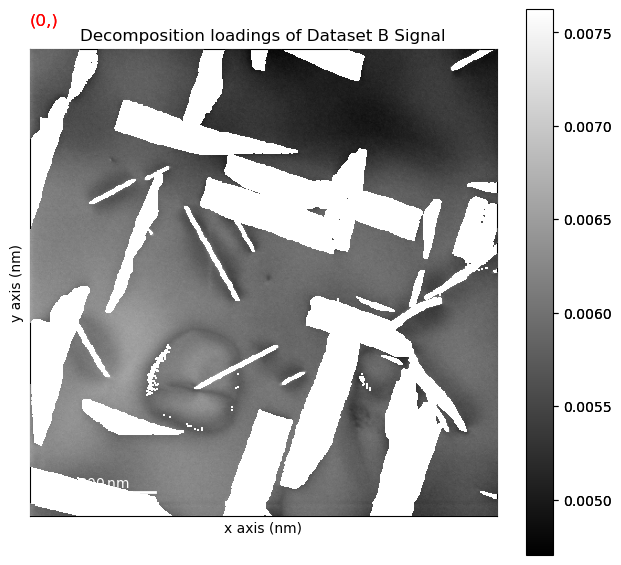

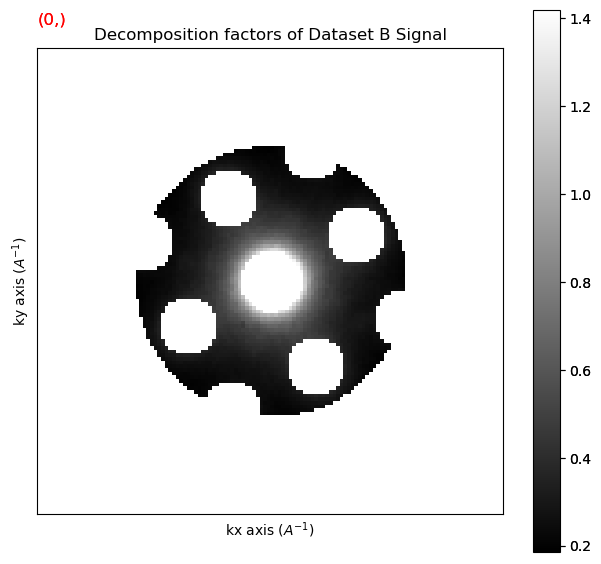

In [48]:
s.plot_decomposition_results()

### NMF

In [49]:
s = hs.load(str(filepath), lazy=False) #Reload data without any decomposition results
s.change_dtype('float32')

output_dimension = 6 #The number of components to allow
tic = time.time()
decomp = s.decomposition(
    normalize_poissonian_noise=True,
    algorithm='NMF',
    output_dimension=output_dimension,
    signal_mask=diffmask,
    navigation_mask=navmask.data.T,
    return_info=True,
    init='nndsvd',
    max_iter=10000
)
toc = time.time()
print(f'Finished decomposition. Elapsed time: {toc - tic} seconds')
print(f'Decoposition parameters: {decomp}')
print(f'Decomposition reconstruction error: {decomp.reconstruction_err_}')
print(f'Decomposition number of iterations: {decomp.n_iter_}')

#Save the decomposition results
s.learning_results.save(filepath.with_name(f'{filepath.stem}_NMF2'), overwrite=True)

#Save the factors and loadings individually as well
factors = s.get_decomposition_factors()
loadings = s.get_decomposition_loadings()
if decomp is not None:
    factors.metadata.add_dictionary({'Decomposition': decomp.__dict__})
    loadings.metadata.add_dictionary({'Decomposition': decomp.__dict__})
factors.save(filepath.with_name(f'{filepath.stem}_NMF2_{output_dimension}_factors.hspy'), overwrite=True)
loadings.save(filepath.with_name(f'{filepath.stem}_NMF2_{output_dimension}_loadings.hspy'), overwrite=True)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=NMF
  output_dimension=6
  centre=None
scikit-learn estimator:
NMF(init='nndsvd', max_iter=10000, n_components=6)
Finished decomposition. Elapsed time: 4332.125074386597 seconds
Decoposition parameters: NMF(init='nndsvd', max_iter=10000, n_components=6)
Decomposition reconstruction error: 0.1720363823803315
Decomposition number of iterations: 6982


[<Axes: title={'center': ' (0,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <Axes: title={'center': ' (1,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <Axes: title={'center': ' (2,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <Axes: title={'center': ' (3,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <Axes: title={'center': ' (4,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <Axes: title={'center': ' (5,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>]

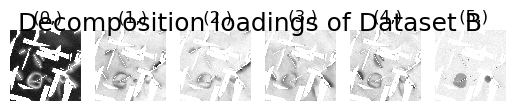

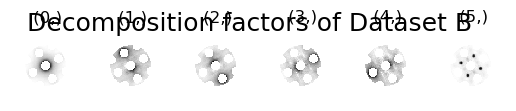

In [50]:
hs.plot.plot_images(loadings, per_row=output_dimension, cmap='gray_r', axes_decor='off', colorbar=None)
hs.plot.plot_images(factors, per_row=output_dimension, cmap='gray_r', norm='symlog', axes_decor='off', colorbar=None)

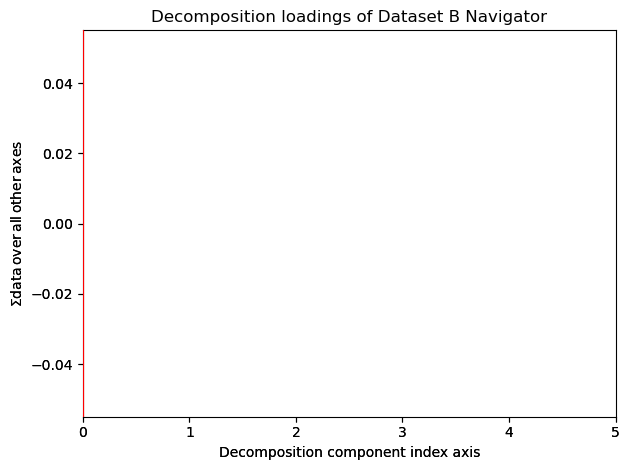

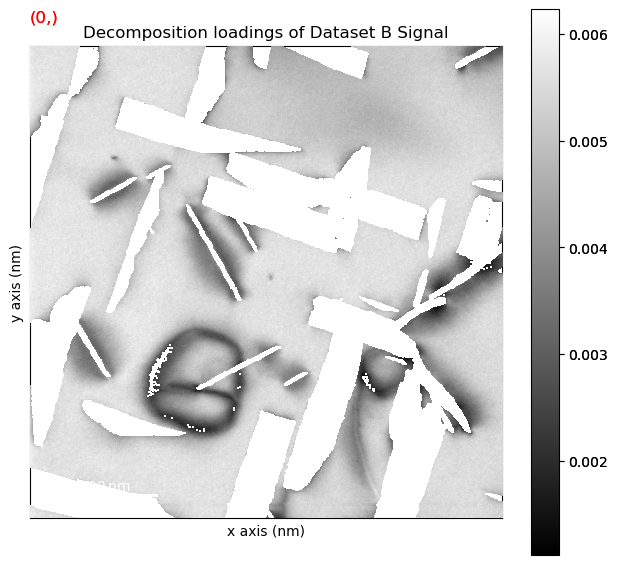

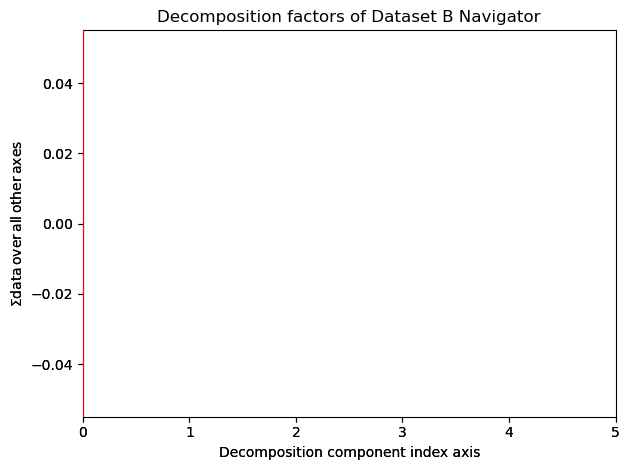

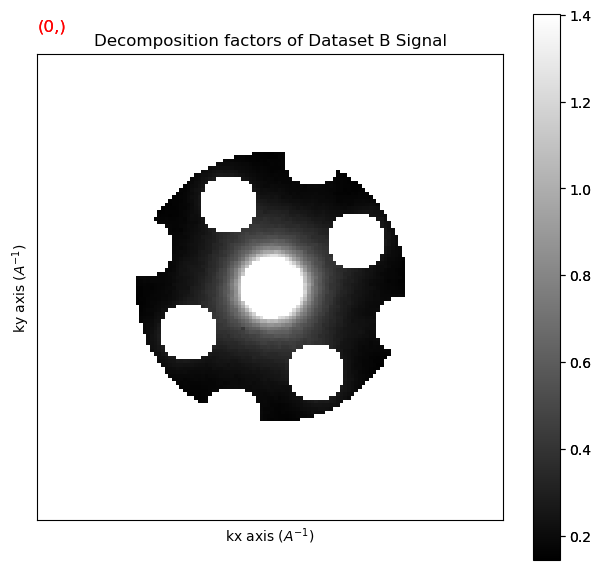

In [51]:
hs.plot.plot_signals([loadings, factors])

In [52]:
phases['theta_001']['components'] = (5,)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


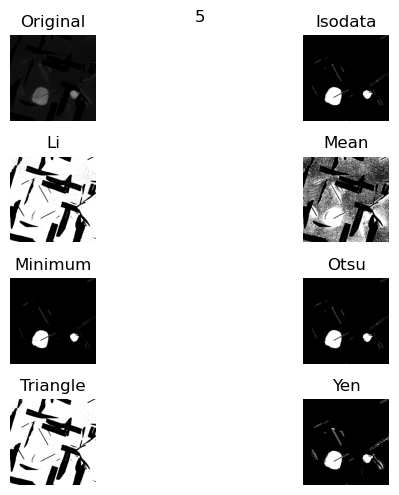

In [53]:
estimate_threshold(loadings, 5)

In [54]:
phases['theta_001']['thresholds'].update({component: estimate_threshold(loadings, component, threshold_isodata) for component in phases['theta_001']['components']})

In [55]:
phases

{'theta_100': {'value': 1.0,
  'components': (1, 3),
  'thresholds': {1: 0.006148654, 3: 0.005472423}},
 'theta_001': {'value': 2.0,
  'components': (5,),
  'thresholds': {5: 0.0031590189664711943}},
 'T1': {'value': 3.0,
  'components': (2, 4),
  'thresholds': {2: 0.0024120628, 4: 0.0022902328}}}

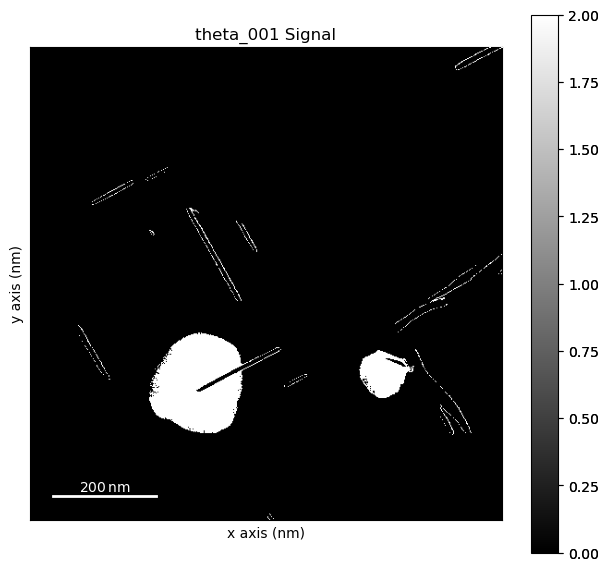

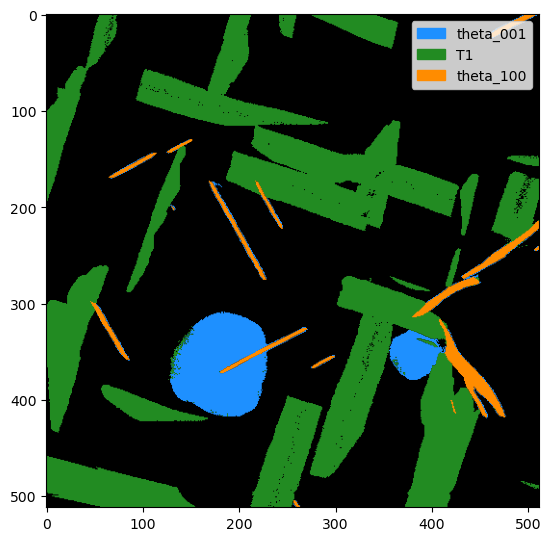

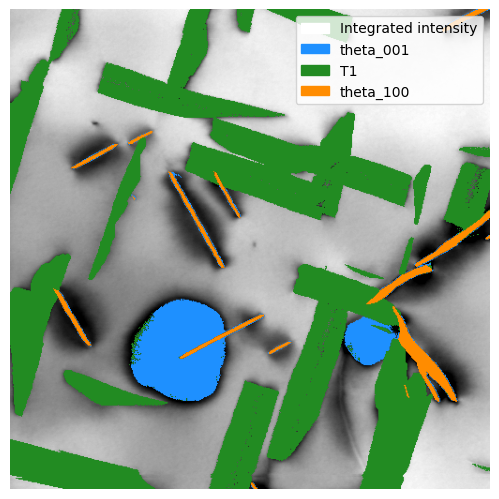

In [56]:
#Create mask signals
theta_001_mask = hs.signals.Signal2D(np.zeros(s.axes_manager.navigation_shape, dtype=bool))
for ax_no, ax in enumerate(s.axes_manager.navigation_axes):
    theta_001_mask.axes_manager[ax_no].name = s.axes_manager[ax].name
    theta_001_mask.axes_manager[ax_no].scale = s.axes_manager[ax].scale
    theta_001_mask.axes_manager[ax_no].units = s.axes_manager[ax].units
    theta_001_mask.axes_manager[ax_no].offset = s.axes_manager[ax].offset
        
#Set mask data for theta_100 
for component in phases['theta_001']['components']:
    theta_001_mask += loadings.inav[component]>=phases['theta_001']['thresholds'][component]
theta_001_mask.metadata.General.title = 'theta_001'
theta_001 = theta_001_mask * phases['theta_001']['value']
theta_001.plot()

hs.plot.plot_images([theta_001, T1, theta_100], overlay=True, colors=[colors[-3], colors[-2], colors[-4]])

if True:
    theta_001.save(filepath.with_name(f'{filepath.stem}_theta_001.hspy'), overwrite=True)

    s.metadata.add_dictionary({'Preprocessing': {'Masks': {'Navigation': {theta_001_mask.metadata.General.title: theta_001_mask}}}})

    hs.plot.plot_images([vbf, theta_001, T1, theta_100], overlay=True, alphas=[1, 1, 1, 1], colors=['w', colors[-3], colors[-2], colors[-4]], axes_decor='off')
    fig = plt.gcf()
    fig.savefig(filepath.with_name(f'{filepath.stem}_theta001_T1_theta100.png'))

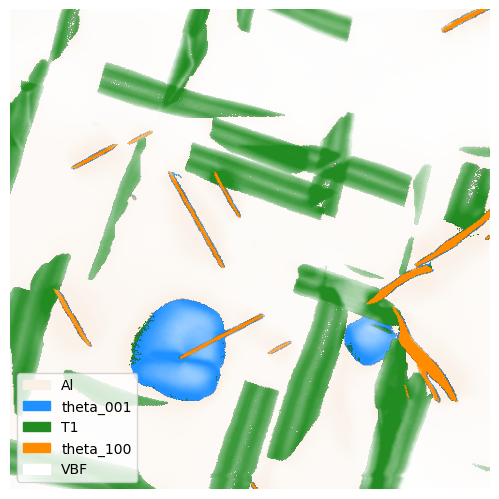

In [57]:
matrix = hs.signals.Signal2D(np.ones(s.axes_manager.navigation_shape, dtype='uint8'))
for ax_no, ax in enumerate(s.axes_manager.navigation_axes):
    matrix.axes_manager[ax_no].name = s.axes_manager[ax].name
    matrix.axes_manager[ax_no].scale = s.axes_manager[ax].scale
    matrix.axes_manager[ax_no].units = s.axes_manager[ax].units
    matrix.axes_manager[ax_no].offset = s.axes_manager[ax].offset
matrix.metadata.General.title = 'Al'

matrix.data[theta_001_mask] = 0
matrix.data[theta_100_mask] = 0
matrix.data[T1_mask] = 0


vbf.metadata.General.title = 'VBF'

if True:
    matrix.save(filepath.with_name(f'{filepath.stem}_matrix.hspy'), overwrite=True)

    s.metadata.add_dictionary({'Preprocessing': {'Masks': {'Navigation': {matrix.metadata.General.title: matrix}}}})

    hs.plot.plot_images([matrix, theta_001, T1, theta_100, vbf], overlay=True, alphas=[1, 1, 1, 1, 1], colors=[colors[0], colors[-3], colors[-2], colors[-4], 'w'], axes_decor='off', legend_loc='lower left')
    fig = plt.gcf()
    fig.savefig(filepath.with_name(f'{filepath.stem}_matrix_theta001_T1_theta100.png'))

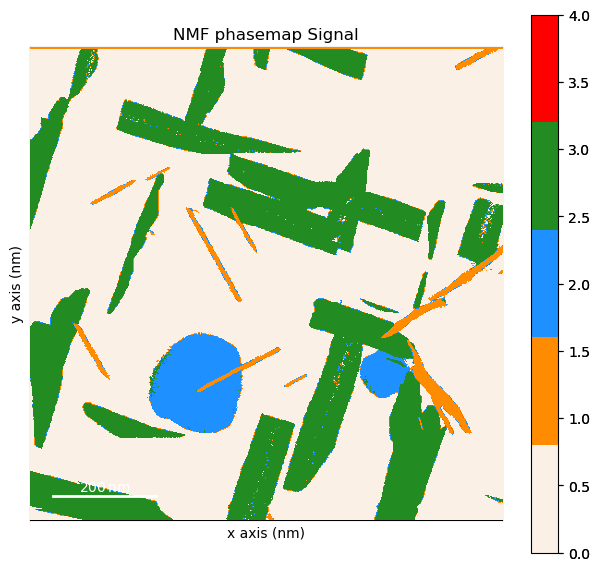

In [58]:
phasemap = hs.signals.Signal2D(np.zeros(s.axes_manager.navigation_shape))
phasemap.data[theta_001_mask] = phases['theta_001']['value']
phasemap.data[T1_mask] = phases['T1']['value']
phasemap.data[theta_100_mask] = phases['theta_100']['value']
phasemap.data[matrix] = 1

for ax_no, ax in enumerate(s.axes_manager.navigation_axes):
    phasemap.axes_manager[ax_no].name = s.axes_manager[ax].name
    phasemap.axes_manager[ax_no].scale = s.axes_manager[ax].scale
    phasemap.axes_manager[ax_no].units = s.axes_manager[ax].units
    phasemap.axes_manager[ax_no].offset = s.axes_manager[ax].offset
phasemap.metadata.General.title = 'NMF phasemap'

phasemap.plot(cmap=cmap, vmax=4)

phasemap.save(filepath.with_name(f'{filepath.stem}_phasemap.hspy'), overwrite=True)

In [59]:
s.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── Diffraction
│       │       ├── camera_length = 23.255992877263527
│       │       └── exposure_time = 10
│       ├── beam_energy = 200
│       ├── rocking_angle = 1.0
│       ├── rocking_frequency = 100
│       └── scan_rotation = 0
├── General
│   ├── FileIO
│   │   ├── 0
│   │   │   ├── hyperspy_version = 1.7.3
│   │   │   ├── io_plugin = hyperspy.io_plugins.hspy
│   │   │   ├── operation = save
│   │   │   └── timestamp = 2023-05-28T13:50:47.670921+02:00
│   │   ├── 1
│   │   │   ├── hyperspy_version = 1.7.3
│   │   │   ├── io_plugin = hyperspy.io_plugins.hspy
│   │   │   ├── operation = load
│   │   │   └── timestamp = 2023-05-28T14:02:08.752018+02:00
│   │   ├── 2
│   │   │   ├── hyperspy_version = 1.7.3
│   │   │   ├── io_plugin = hyperspy.io_plugins.hspy
│   │   │   ├── operation = save
│   │   │   └── timestamp = 2023-05-28T14:13:26.013839+02:00
│   │   └── 3
│   │       ├── hyperspy_version = 1.7.3
│   │       ├── io_plugin = hyperspy.io_plugins.hspy
│   │       ├── operation = load
│   │       └── timestamp = 2023-07-04T05:35:20.814762+02:00
│   └── title = Dataset B
├── Preprocessing
│   ├── Centering
│   │   ├── COM = <DPCSignal2D, title: , dimensions: (2|512, 512)>
│   │   ├── COM_mask
│   │   │   ├── r = 12.5
│   │   │   ├── x = 125
│   │   │   └── y = 125
│   │   ├── Shifts = <BeamShift, title: , dimensions: (512, 512|2)>
│   │   └── shift_estimate_mask = <BaseSignal, title: , dimensions: (512, 512|)>
│   └── Masks
│       ├── Diffraction
│       │   ├── cutoff = <Signal2D, title: <7.001e-01 $A^{-1}$ mask, dimensions: (|128, 128)>
│       │   ├── direct_beam = <Signal2D, title: >1.595e-01 $A^{-1}$ mask, dimensions: (|128, 128)>
│       │   └── reflections = <Signal2D, title: Reflection mask, dimensions: (|128, 128)>
│       └── Navigation
│           ├── Al = <Signal2D, title: Al, dimensions: (|512, 512)>
│           └── theta_001 = <Signal2D, title: theta_001, dimensions: (|512, 512)>
└── Signal
    └── signal_type = electron_diffraction